# HW1 : Regression, Cross-Validation, and  Regularization

In [121]:
import os
import numpy as np
import pandas as pd
 
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.linear_model

In [122]:
from matplotlib import pyplot as plt

import seaborn as sns
sns.set('notebook', font_scale=1.25, style='whitegrid')

### Configuration

In [123]:
SEED = 12345 

DATA_DIR = 'data_auto/'

### Methods for loading dataset

In [124]:
def load_2d_arr_from_csv(fname, include_header=False):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    assert x.ndim == 2
    if include_header:
        header_cols = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', dtype=str)[0].tolist()
        return x, header_cols
    else:
        return x
    
def load_1d_arr_from_csv(fname):
    x = np.loadtxt(os.path.join(DATA_DIR, fname), delimiter=',', skiprows=1)
    if x.ndim == 1:
        return x
    else:
        raise ValueError("Not 1d")

# Load the dataset

Predefined 'x' and 'y' arrays for train/valid/test

In [125]:
x_tr_MF, xcolnames_F = load_2d_arr_from_csv('x_train.csv', include_header=True)
x_va_NF = load_2d_arr_from_csv('x_valid.csv')
x_te_PF = load_2d_arr_from_csv('x_test.csv')

In [126]:
print(xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']


In [127]:
print(x_tr_MF[:5])

[[ 115. 2595.    6.  173.]
 [ 180. 4380.    8.  350.]
 [ 150. 4457.    8.  318.]
 [ 105. 3897.    6.  250.]
 [ 193. 4732.    8.  304.]]


In [128]:
y_tr_M = load_1d_arr_from_csv('y_train.csv')
y_va_N = load_1d_arr_from_csv('y_valid.csv')
y_te_P = load_1d_arr_from_csv('y_test.csv')

In [129]:
print(y_tr_M[:5,np.newaxis])

[[28.8]
 [16.5]
 [14. ]
 [16. ]
 [ 9. ]]


In [130]:
y_tr_M.max()

46.6

In [131]:
Y_MAX = 60.0

## Load completed code

In [132]:
from performance_metrics import calc_root_mean_squared_error
from cross_validation import train_models_and_calc_scores_for_n_fold_cv

## Define useful plotting functions

In [133]:
def plot_train_and_valid_error_vs_hyper(
        hyper_list, err_tr_list=None, err_va_list=None,
        ymax=40,
        leg_loc='upper right',
        xlabel='polynomial degree',
        ylabel='RMSE'):
    if err_va_list is not None:
        plt.plot(hyper_list, err_va_list, 'rs-', label='valid');
    if err_tr_list is not None:
        plt.plot(hyper_list, err_tr_list, 'bd:', label='train');
    plt.ylim([0, ymax]);
    plt.legend(loc=leg_loc);
    plt.xlabel(xlabel);
    plt.ylabel(ylabel);

## Method to sanitize predictions

We are predicting MPG, which should 
* (1) always be positive, and
* (2) will probably never exceed 120% of the largest value we see in train data

In [134]:
def sanitize(yhat_N):
    yhat_N = np.maximum(yhat_N, 0)
    yhat_N = np.minimum(yhat_N, Y_MAX)
    return yhat_N

In [135]:
bad_yhat_N = np.asarray([-10, -1, 0, 1, 5, 10, 50, 55, 60, 65])

In [136]:
bad_yhat_N

array([-10,  -1,   0,   1,   5,  10,  50,  55,  60,  65])

In [137]:
sanitize(bad_yhat_N)

array([ 0.,  0.,  0.,  1.,  5., 10., 50., 55., 60., 60.])

## Methods for building pipelines

In [138]:
def make_poly_linear_regr_pipeline(degree=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LinearRegression()),
        ])
    
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [139]:
def make_poly_ridge_regr_pipeline(degree=1, alpha=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         ('rescaler', sklearn.preprocessing.MinMaxScaler()),
         ('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.Ridge(alpha=alpha)),
        ])

    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

## Method to inspect learned weights

In [140]:
def pretty_print_learned_weights(pipeline, xcolnames_F):
    ''' Print the learned parameters of given pipeline
    '''
    my_lin_regr = pipeline.named_steps['linear_regr']

    feat_names = pipeline.named_steps['poly_transformer'].get_feature_names_out()
    coef_values = my_lin_regr.coef_

    for feat, coef in zip(feat_names, coef_values):
        print("% 7.2f : %s" % (coef, feat))
    
    print("where ")
    for ff, colname in enumerate(xcolnames_F):
        print("x%d = %s" % (ff, colname))

# Problem 1: Polynomial Degree Selection on Fixed Validation Set

**Implementation Step 1A:**

Fit a linear regression model to a polynomial feature transformation of the provided training set at each of these possible degrees: [1, 2, 3, 4, 5, 6, 7]. For each hyperparameter setting, record the training set error and the validation set error.

In [141]:
degree_list = [1, 2, 3, 4, 5, 6, 7]
fv_err_tr_list = []
fv_err_va_list = []

fv_pipeline_list = []
for degree in degree_list:

    # TODO create a pipeline using features with current degree value
    # TODO train this pipeline on provided training data
    pipeline = make_poly_linear_regr_pipeline(degree)
    
    pipeline.fit(x_tr_MF, y_tr_M)

    # Compute training error
    yhat_tr_M = pipeline.predict(x_tr_MF)  # TODO fixme, be sure to sanitize predictions
    yhat_tr_M = sanitize(yhat_tr_M)
    yhat_va_N = pipeline.predict(x_va_NF)  # TODO fixme, be sure to sanitize predictions
    yhat_va_N = sanitize(yhat_va_N)

    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv_err_tr_list.append(err_tr)
    fv_err_va_list.append(err_va)

    # TODO store current pipeline for future use
    fv_pipeline_list.append(pipeline)

### Figure 1: Error vs degree

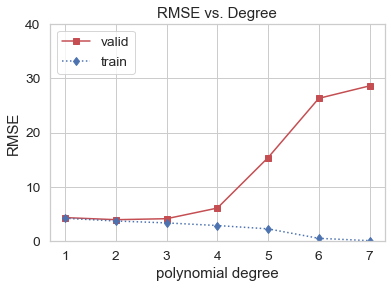

In [142]:
plot_train_and_valid_error_vs_hyper(
    degree_list, fv_err_tr_list, fv_err_va_list, leg_loc='upper left');
plt.title('RMSE vs. Degree');

### Implementation 1B: Score on the test set using the chosen model

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained LinearRegression model with these best hyperparameters, compute error on the *test* set. Save this test set error value for later.

In [143]:
# Find the degree corresponding to the minimum validation error
min_err_va_degree = degree_list[np.argmin(fv_err_va_list)]
print("Selected Parameters:")
print(min_err_va_degree)

print("Fixed validation set estimate of heldout error:")
print(fv_err_va_list[np.argmin(fv_err_va_list)])

# Set the degree parameter of the polynomial features transformation in the pipeline to the selected degree
pipeline = fv_pipeline_list[min_err_va_degree-1]

# Now, use the modified pipeline to make predictions on the test set
yhat_te_P = pipeline.predict(x_te_PF)  # Assuming x_te_PF contains test set features
yhat_te_P = sanitize(yhat_te_P)

# Calculate the error on the test set
err_te = calc_root_mean_squared_error(y_te_P, yhat_te_P)  # Assuming y_te_P contains test set targets
print("Error on the test-set:")
print(err_te)

Selected Parameters:
2
Fixed validation set estimate of heldout error:
3.974075330754534
Error on the test-set:
3.9915025464567635


In [144]:
err_te_list = []
err_te_list.append(err_te)

### Short Answer 1a in Report

Investigate why preprocessing is necessary

In [145]:
# WRITE THIS IN YOUR REPORT, NOT IN THIS NOTEBOOK

### Short Answer 1b in Report

Consider the model with degree 1. 
Following the starter code, print out the values of **all** the learned weight parameters (aka coefficients).

In [146]:
# TODO call pretty_print_learned_weights on your pipeline with degree=1 from above
# Hint: The names of the original F=4 features are already in your workspace

print(xcolnames_F)
pretty_print_learned_weights(fv_pipeline_list[0], xcolnames_F)

['horsepower', 'weight', 'cylinders', 'displacement']
 -10.43 : x0
 -18.23 : x1
  -1.15 : x2
   0.58 : x3
where 
x0 = horsepower
x1 = weight
x2 = cylinders
x3 = displacement


### Short Answer 1c in Report

Consider the models with degree 3 or 4. 
Inspect the learned weight parameters, including the number of parameters and their relative magnitudes.

What do you notice about these values compared to the values with degree 1 or 2?
How might what you notice be connected to the trends in training and validation set performance you observe in Figure 1?

In [147]:
# TODO
pretty_print_learned_weights(fv_pipeline_list[3], xcolnames_F)

 617.45 : x0
-191.08 : x1
 1774.24 : x2
-1343.56 : x3
 159.25 : x0^2
-323.66 : x0 x1
-5179.64 : x0 x2
 198.45 : x0 x3
  61.37 : x1^2
 2573.25 : x1 x2
-1596.95 : x1 x3
-5943.40 : x2^2
 7359.52 : x2 x3
 2883.15 : x3^2
-630.58 : x0^3
 1377.51 : x0^2 x1
-1600.47 : x0^2 x2
 1529.25 : x0^2 x3
-105.12 : x0 x1^2
-7880.76 : x0 x1 x2
 12085.95 : x0 x1 x3
 13051.50 : x0 x2^2
 5626.91 : x0 x2 x3
-14222.70 : x0 x3^2
 611.22 : x1^3
-1478.94 : x1^2 x2
-359.76 : x1^2 x3
-7343.55 : x1 x2^2
 17674.97 : x1 x2 x3
-13648.53 : x1 x3^2
 4525.05 : x2^3
  47.94 : x2^2 x3
-34068.88 : x2 x3^2
 20804.11 : x3^3
-345.94 : x0^4
 1047.47 : x0^3 x1
 133.89 : x0^3 x2
 702.32 : x0^3 x3
 1031.68 : x0^2 x1^2
 3678.25 : x0^2 x1 x2
-11633.91 : x0^2 x1 x3
-1147.94 : x0^2 x2^2
 1506.00 : x0^2 x2 x3
 3042.21 : x0^2 x3^2
-5637.55 : x0 x1^3
 3990.55 : x0 x1^2 x2
 7624.03 : x0 x1^2 x3
 12467.48 : x0 x1 x2^2
-36650.46 : x0 x1 x2 x3
 19120.42 : x0 x1 x3^2
-6959.36 : x0 x2^3
-12414.29 : x0 x2^2 x3
 31670.59 : x0 x2 x3^2
-15448.88 : 

# Problem 2: Alpha Selection on Fixed Val Set

In [148]:
my_degree = 4
alpha_list = np.asarray([1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04, 1.e+06])
print(alpha_list)

[1.e-10 1.e-08 1.e-06 1.e-04 1.e-02 1.e+00 1.e+02 1.e+04 1.e+06]


In [149]:
fv2_err_tr_list = []
fv2_err_va_list = []
fv2_pipeline_list = []

for alpha in alpha_list:

    # TODO create a pipeline using features with current degree value
    pipeline2 = make_poly_ridge_regr_pipeline(my_degree, alpha)
    # TODO train this pipeline on provided training data

    pipeline2.fit(x_tr_MF, y_tr_M)

    yhat_tr_M = pipeline2.predict(x_tr_MF)  # TODO fixme, be sure to sanitize predictions
    yhat_tr_M = sanitize(yhat_tr_M)
    
    yhat_va_N = pipeline2.predict(x_va_NF)  # TODO fixme, be sure to sanitize predictions
    yhat_va_N = sanitize(yhat_va_N)

    assert np.all(yhat_va_N >= 0.0)
    assert np.all(yhat_va_N <= Y_MAX)
    
    err_tr = calc_root_mean_squared_error(y_tr_M, yhat_tr_M) # TODO fixme
    err_va = calc_root_mean_squared_error(y_va_N, yhat_va_N) # TODO fixme

    fv2_err_tr_list.append(err_tr)
    fv2_err_va_list.append(err_va)

    # TODO store current pipeline for future use
    fv2_pipeline_list.append(pipeline2)

### Figure 2 in report

Make a line plot of mean-squared error on y-axis vs. alpha on x-axis.

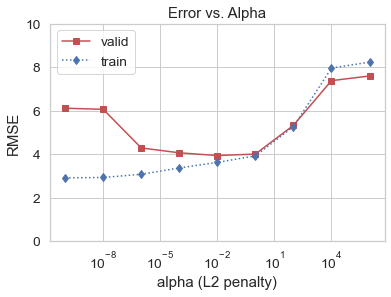

In [150]:
plot_train_and_valid_error_vs_hyper(
    alpha_list, fv2_err_tr_list, fv2_err_va_list,
    xlabel='alpha (L2 penalty)', leg_loc='upper left');
plt.gca().set_ylim([0, 10]);
plt.gca().set_xscale('log');
plt.title('Error vs. Alpha');

### Implementation Step 2B

Select the model hyperparameters that *minimize* your fixed validation set error. Using your already-trained model with these best hyperparameters, compute error on the *test* set. 


In [151]:
index = fv2_err_va_list.index(min(fv2_err_va_list))
print("Selected Parameters:")
print(alpha_list[index])
print("Fixed validation set estimate of heldout error:")
print(fv2_err_va_list[index])

pipeline2 = fv2_pipeline_list[index]

# Now, use the modified pipeline to make predictions on the test set
yhat_te_P = pipeline2.predict(x_te_PF)  # Assuming x_te_PF contains test set features
yhat_te_P = sanitize(yhat_te_P)

# Calculate the error on the test set
err_te = calc_root_mean_squared_error(y_te_P, yhat_te_P)  # Assuming y_te_P contains test set targets
print("Error on the test-set:")
print(err_te)

Selected Parameters:
0.01
Fixed validation set estimate of heldout error:
3.931387833481243
Error on the test-set:
3.877667860403774


In [152]:
# TODO Save this test set error value for later.
err_te_list.append(err_te)

### Short Answer 2a in Report

Inspect the learned weight parameters of your chosen degree-4 model.
What do you notice about the relative magnitudes compared to 1c above?

In [153]:
pretty_print_learned_weights(fv2_pipeline_list[index], xcolnames_F)

 -39.88 : x0
   1.56 : x1
  14.71 : x2
 -13.32 : x3
  -6.53 : x0^2
  -5.93 : x0 x1
  21.96 : x0 x2
  24.36 : x0 x3
 -22.82 : x1^2
   2.39 : x1 x2
  -2.18 : x1 x3
 -19.42 : x2^2
 -26.81 : x2 x3
   3.47 : x3^2
   9.93 : x0^3
   5.41 : x0^2 x1
   9.37 : x0^2 x2
  14.07 : x0^2 x3
   8.22 : x0 x1^2
   7.41 : x0 x1 x2
  12.85 : x0 x1 x3
   0.12 : x0 x2^2
  -1.49 : x0 x2 x3
   0.97 : x0 x3^2
  -5.93 : x1^3
  -2.12 : x1^2 x2
  -2.79 : x1^2 x3
   0.19 : x1 x2^2
  -2.80 : x1 x2 x3
  -0.49 : x1 x3^2
  -4.76 : x2^3
  -3.17 : x2^2 x3
   3.10 : x2 x3^2
   5.33 : x3^3
   5.15 : x0^4
  -4.71 : x0^3 x1
  -1.87 : x0^3 x2
   5.64 : x0^3 x3
  -2.97 : x0^2 x1^2
  -5.04 : x0^2 x1 x2
   1.79 : x0^2 x1 x3
 -10.96 : x0^2 x2^2
  -4.93 : x0^2 x2 x3
  -3.79 : x0^2 x3^2
   4.44 : x0 x1^3
   2.40 : x0 x1^2 x2
   5.23 : x0 x1^2 x3
  -4.37 : x0 x1 x2^2
  -0.25 : x0 x1 x2 x3
  -1.68 : x0 x1 x3^2
 -16.61 : x0 x2^3
 -11.02 : x0 x2^2 x3
 -10.19 : x0 x2 x3^2
 -13.04 : x0 x3^3
   2.39 : x1^4
   3.05 : x1^3 x2
   0.24 : x1^

# Data preprocessing for Problem 3

For this problem, you'll again use the provided training set and validation sets. However, you'll *merge* these into a large "development" set that contains 292 examples total.

In [154]:
x_trva_LF = np.vstack([x_tr_MF, x_va_NF])
y_trva_L = np.hstack([y_tr_M, y_va_N])

print(x_trva_LF.shape)

(292, 4)


# Problem 3: Cross Validation for Polynomial Feature Regression

### Implementation step 3A

For each possible `alpha` value as well as each possible polynomial degree, train and evaluate a `Ridge` regression model across the entire train+validation set using 10-fold cross validation. Use the CV methods you implemented in `cross_validation.py`. For each possible hyperparameter (alpha value and degree value), your 10-fold CV procedure will give you an estimate of the training error and heldout validation error (averaged across all folds). 


In [155]:
K = 10 # num folds of CV
degree_list = [1, 2, 3, 4, 5, 6, 7]
alpha_list = np.logspace(-10, 6, 17)

ridge_param_list = []
for alpha in alpha_list:
    for degree in degree_list:
        ridge_param_list.append(dict(degree=degree, alpha=alpha))
        
cv_train_err_list = []
cv_valid_err_list = []
cv_pipeline_list = []
for param in ridge_param_list:
    degree = param['degree']
    alpha = param['alpha']
    pipeline3 = make_poly_ridge_regr_pipeline(degree, alpha)
    
    # TODO call your function to train a separate model for each fold and return train and valid errors
    # Don't forget to pass random_state = SEED (where SEED is defined above) so its reproducible
    # tr_error_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv() # TODO

    tr_err_K, valid_error_K = train_models_and_calc_scores_for_n_fold_cv(pipeline3, x_trva_LF, y_trva_L, K, SEED)

    err_tr = np.mean(tr_err_K) # TODO fixme, compute average error across all train folds
    err_va = np.mean(valid_error_K) # TODO fixme, compute average error across all heldout folds
    
    cv_train_err_list.append(err_tr)
    cv_valid_err_list.append(err_va)

    cv_pipeline_list.append(pipeline3)

### Implementation step 3B

Select the model hyperparameters that *minimize* your estimated cross-validation error. Using these best hyperparameters, retrain the model using the full development set (concatenating the predefined training and validation sets). Then compute that (retrained) model's error on the test set.

Save this test set error value for later.

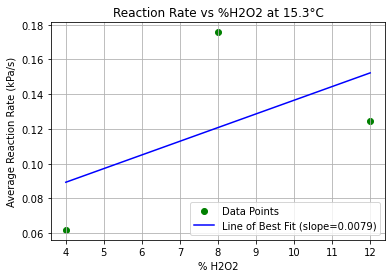

Slope of the line of best fit: 0.007870812499999992


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Additional data points
x_data_additional = np.array([12, 8, 4])  # % H2O2
y_data_additional = np.array([0.12483, 0.1756635, 0.0618635])  # Reaction rate in kPa/s

# Perform linear regression to find the slope (m) and intercept (b)
m_additional, b_additional = np.polyfit(x_data_additional, y_data_additional, 1)

# Generate the line of best fit
x_fit_additional = np.linspace(min(x_data_additional), max(x_data_additional), 100)
y_fit_additional = m_additional * x_fit_additional + b_additional

# Plot the data points and the line of best fit
plt.scatter(x_data_additional, y_data_additional, label='Data Points', color='green')
plt.plot(x_fit_additional, y_fit_additional, color='blue', label=f'Line of Best Fit (slope={m_additional:.4f})')

# Add labels, title, and legend
plt.xlabel('% H2O2')
plt.ylabel('Average Reaction Rate (kPa/s)')
plt.title('Reaction Rate vs %H2O2 at 15.3°C')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Print the slope
print("Slope of the line of best fit:", m_additional)


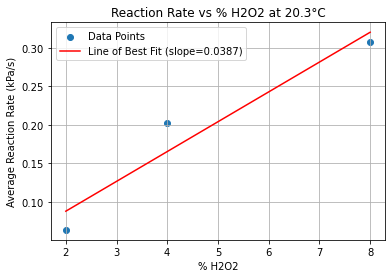

Slope of the line of best fit: 0.038722321428571425


In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Data points
x_data = np.array([2, 4, 8])  # % H2O2
y_data = np.array([0.06375, 0.2019125, 0.3082275])  # Reaction rate in kPa/s

# Perform linear regression to find the slope (m) and intercept (b)
m, b = np.polyfit(x_data, y_data, 1)

# Generate the line of best fit
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = m * x_fit + b

# Plot the data points and the line of best fit
plt.scatter(x_data, y_data, label='Data Points')
plt.plot(x_fit, y_fit, color='red', label=f'Line of Best Fit (slope={m:.4f})')

# Add labels and legend
plt.xlabel('% H2O2')
plt.ylabel('Average Reaction Rate (kPa/s)')
plt.title('Reaction Rate vs % H2O2 at 20.3°C')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

# Print the slope
print("Slope of the line of best fit:", m)


In [157]:
index = cv_valid_err_list.index(min(cv_valid_err_list))
print(index)
best_param = ridge_param_list[index]

print("Selected Parameters:")
print("best degree: ", best_param['degree'])
print("best alpha: ", best_param['alpha'])

print("10-fold CV estimate of heldout error:")
print(cv_valid_err_list[index])

pipeline3 = cv_pipeline_list[index]

# Now, use the modified pipeline to make predictions on the test set
yhat_te_P = pipeline3.predict(x_te_PF)  # Assuming x_te_PF contains test set features
yhat_te_P = sanitize(yhat_te_P)

# Calculate the error on the test set
err_te = calc_root_mean_squared_error(y_te_P, yhat_te_P)  # Assuming y_te_P contains test set targets
print("Error on the test-set:")
print(err_te)

err_te_list.append(err_te)

69
Selected Parameters:
best degree:  7
best alpha:  0.1
10-fold CV estimate of heldout error:
3.86811
Error on the test-set:
3.8299907901848718


## Table 3 : Comparing pipelines on test set

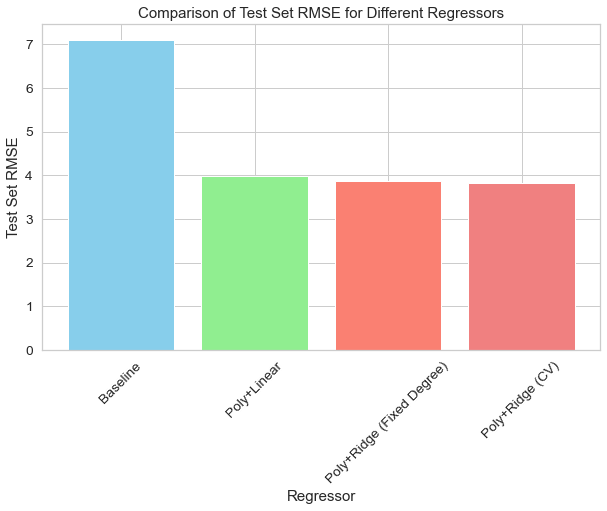

                   Regressor  Test Set RMSE
0                   Baseline       7.104481
1                Poly+Linear       3.991503
2  Poly+Ridge (Fixed Degree)       3.877668
3            Poly+Ridge (CV)       3.829991


In [163]:
from sklearn.base import BaseEstimator, TransformerMixin

class BaselinePredictor(BaseEstimator, TransformerMixin):
    def fit(self, X, y):
        self.mean_y = np.mean(y)
        return self
    
    def predict(self, X):
        return np.full(X.shape[0], self.mean_y)

base = BaselinePredictor()
base.fit(x_tr_MF, y_tr_M)
y_hat = base.predict(x_te_PF)

base_err = calc_root_mean_squared_error(y_te_P, y_hat)

# Define the regressor names
regressors = ["Baseline", "Poly+Linear", "Poly+Ridge (Fixed Degree)", "Poly+Ridge (CV)"]

# Define the RMSE values for each regressor (example placeholder values)
rmse_values = [base_err, err_te_list[0], err_te_list[1], err_te_list[2]]

# Define colors for each bar
colors = ['skyblue', 'lightgreen', 'salmon', 'lightcoral']

# Create a bar graph with different colors for each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(regressors, rmse_values, color=colors)

# Add labels and title
plt.xlabel('Regressor')
plt.ylabel('Test Set RMSE')
plt.title('Comparison of Test Set RMSE for Different Regressors')

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Display the bar graph
plt.show()





# Create a pandas DataFrame with the regressor names and RMSE values
df = pd.DataFrame({
    'Regressor': regressors,
    'Test Set RMSE': rmse_values
})

# Display the DataFrame
print(df)


This is the 2024S version of this assignment. Please do not remove or make changes to this block. Otherwise, you submission will be viewed as files copied from other resources.